# Part2 - Starategy Mining for Thera Bank Loan Modelling

## Data Cleansing and Mining

### There are three parts to this notebook
1. Data Importing:
>* This partt includes improting necessary Python libraries and reading from the data file.
2. Data Cleansing:
>* This part includes cleaning the data of empty, -ve or NaN values.
3. Data Mining:
>* This includes different stages of mining topn N conditions for marketing strategy.

## (1) Data Importing

### Import Python libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from pycaret.classification import *
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import seaborn as sns
import itertools
import re
import datetime

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
pd.set_option('display.max_colwidth', 500)

### Read the CSV file into a data frame 

In [2]:
df = pd.read_csv("Bank_Personal_Loan_Modelling.csv")
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


### Listing Data types of each column.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


### Listing the number of NANs and Zeros in the Data Frame


In [4]:

pd.DataFrame({'Column Name':df.columns,
              'NANs':list(df.isna().sum()),
              'Zeros':[df[df[i] == 0 ][i].count() for i in df.columns],
             'Negatives':[df[df[j] < 0 ][j].count() for j in df.columns] })


,Column Name,NANs,Zeros,Negatives
0,ID,0,0,0
1,Age,0,0,0
2,Experience,0,66,52
3,Income,0,0,0
4,ZIP Code,0,0,0
5,Family,0,0,0
6,CCAvg,0,106,0
7,Education,0,0,0
8,Mortgage,0,3462,0
9,Personal Loan,0,4520,0


####  Observations:  
    As we can see there are no NANs in the data frame but there are columns with zero value which could be genuine values for most categorical and continuous variables ansd also is a valid class label. This may be an exception to the "Experience" column where '-1' value is not expected. We have also seen in the EDA the columns 'Age' and 'Experience' shows very high correlation and hence one of them could be removed.


### Testing for Multi Collineratity using VIF ( Variance Inflation Factor)  

In [5]:
def get_VIF_Table(df):
    '''
    Function to get the Variance Inflation Factor from the data frame:
    Usage: get_VIF_Table(pd.DataFrame)
    (1) df : Dataframe
    
    Return:
        Returns the Table containing the list of column names or features and VIF for each of them.
    '''
    X = df
    vif_data = pd.DataFrame() 
    vif_data["feature"] = X.columns 
    vif_data["VIF"] =[variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
    return vif_data

In [6]:
get_VIF_Table(df)

,feature,VIF
0,ID,4.009583
1,Age,1277.706913
2,Experience,315.410677
3,Income,7.862705
4,ZIP Code,368.301738
5,Family,5.686767
6,CCAvg,3.873128
7,Education,7.213509
8,Mortgage,1.377017
9,Personal Loan,1.801703


In [7]:
## Rerun the VIF fucntion without Experience and ZIP Code
get_VIF_Table(df.drop(['Experience','ZIP Code'],axis=1))

,feature,VIF
0,ID,3.701853
1,Age,9.700201
2,Income,6.831337
3,Family,4.616811
4,CCAvg,3.842769
5,Education,5.508880
6,Mortgage,1.372959
7,Personal Loan,1.685391
8,Securities Account,1.268647
9,CD Account,1.531426


#### Observation: 
    As we could see from the list above that 'Age' and 'Experience' are highly correlated and so is the 'ZIP Code'. But 'ZIP Code could be treated as a nominal variable and their value does not hold any special significance. We will reformat this variable 'ZIP Code' to the first to digits only and check for multi collinearity in the next step. Also, the column 'Experience' can be removed while modelling the data. 
    Re-running the check by removing 'Experience' and 'ZIP Code'reduces the VIF significantly. We will regularize these values while modelling.

### Set ID as the index of the data frame 

In [8]:

df.set_index("ID",inplace=True)

### Define a function to create lists of continuous and categorical variables

In [9]:
## Function to create the list of continuous and categorical variables.
def create_variable_list(df,min_cats,stats=False):
    '''
    Function for categoring the continuous and categorical columns 
    Usage: 
        create_variable_list(df,min_cats,stats):
        (1) df : Pandas data frame.
        (2) min_cats : Threshold for a variables to be deemed as a Categorical Variable
        (3) stats :( dafult=False) Return a table of variable name, variable type, number of unique values and list of unique values.
                    
        Return : Returns two lists each with categorical and continuous variables respectively.
                 Also if stats=True, then return a table of data types
        
    '''
    categorical =[]
    continuous= []
    for col in df.columns:
        if df[col].nunique() > min_cats :
            continuous.append(col)
        else:
            categorical.append(col)
    if stats == True :

        var_df = pd.DataFrame(columns=['Variable',
                                       'Variable Type',
                                       'Unique Values',
                                       'Number of unique Values'])
        
        for cats in categorical:
            var_df = var_df.append({'Variable' : cats,
                                    'Variable Type' :'Categorical',
                                    'Unique Values': df[cats].unique(),
                                    'Number of unique Values': len(df[cats].unique())},
                                   ignore_index=True)
        for conts in continuous:
            var_df = var_df.append({'Variable' : conts,
                                    'Variable Type' :'Continuous',
                                    'Unique Values': df[conts].unique(),
                                    'Number of unique Values': len(df[conts].unique())},
                                   ignore_index=True)
        return categorical,continuous,var_df
    else:
        return categorical,continuous


In [10]:
### Test create_variable_list(df,10)
cat_var_list,cont_var_list,cats_df1= create_variable_list(df,10,stats=True)
# print(f"(1) Categorical Variables :{cat_var_list}\n(2)Continuous Variables :{cont_var_list}")
cats_df1

,Variable,Variable Type,Unique Values,Number of unique Values
0,Family,Categorical,"[4, 3, 1, 2]",4
1,Education,Categorical,"[1, 2, 3]",3
2,Personal Loan,Categorical,"[0, 1]",2
3,Securities Account,Categorical,"[1, 0]",2
4,CD Account,Categorical,"[0, 1]",2
5,Online,Categorical,"[0, 1]",2
6,CreditCard,Categorical,"[0, 1]",2
7,Age,Continuous,"[25, 45, 39, 35, 37, 53, 50, 34, 65, 29, 48, 59, 67, 60, 38, 42, 46, 55, 56, 57, 44, 36, 43, 40, 30, 31, 51, 32, 61, 41, 28, 49, 47, 62, 58, 54, 33, 27, 66, 24, 52, 26, 64, 63, 23]",45
8,Experience,Continuous,"[1, 19, 15, 9, 8, 13, 27, 24, 10, 39, 5, 23, 32, 41, 30, 14, 18, 21, 28, 31, 11, 16, 20, 35, 6, 25, 7, 12, 26, 37, 17, 2, 36, 29, 3, 22, -1, 34, 0, 38, 40, 33, 4, -2, 42, -3, 43]",47
9,Income,Continuous,"[49, 34, 11, 100, 45, 29, 72, 22, 81, 180, 105, 114, 40, 112, 130, 193, 21, 25, 63, 62, 43, 152, 83, 158, 48, 119, 35, 41, 18, 50, 121, 71, 141, 80, 84, 60, 132, 104, 52, 194, 8, 131, 190, 44, 139, 93, 188, 39, 125, 32, 20, 115, 69, 85, 135, 12, 133, 19, 82, 109, 42, 78, 51, 113, 118, 64, 161, 94, 15, 74, 30, 38, 9, 92, 61, 73, 70, 149, 98, 128, 31, 58, 54, 124, 163, 24, 79, 134, 23, 13, 138, 171, 168, 65, 10, 148, 159, 169, 144, 165, ...]",162


## (2) Data Cleansing

#### (1) ZIP Code

In [11]:
df[df['ZIP Code'].astype(str).map(len) < 5]

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,
385,51,25,21,9307,4,0.6,3,0,0,0,0,1,1


#### There is one value with index 385 with a 4 digit code 9307 while all others in the ZIP Code had a length of 5 digts. Hence multiplying it with 10 to make it 5 digits. We will create a new column "ZIPCode Prefix" with only 2 digit code so that we could get a broad location as well as we could convert this into a categorical data.

In [12]:
df['ZIP Code'] = df['ZIP Code'].apply(lambda x : x*10 if len(str(x)) < 5 else x)
df[df['ZIP Code'].astype(str).map(len) < 5]

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,


In [13]:
df['ZIPCode Prefix']=df['ZIP Code'].apply(lambda x : int(x/1000))
df.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,ZIPCode Prefix
ID,,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0,91
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0,90
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0,94
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0,94
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1,91


### Converting continuous variables into categorical variables by binning them
#### (1) CCAvg -> CCAvg-Bin

In [14]:
print(f"Minimum value in CCAvg is {df['CCAvg'].min()} and maximum is {df['CCAvg'].max()}")

Minimum value in CCAvg is 0.0 and maximum is 10.0


    There is a minimum of 0.0 and maximum of 10 Credit Cards. Hence we could categorise them into 10 bins

In [15]:
df['CCAvg-Bin'] = pd.cut(df['CCAvg'],bins=10,right=False,precision=0)
df[['CCAvg','CCAvg-Bin']].head()

,CCAvg,CCAvg-Bin
ID,,
1,1.6,"[1.0, 2.0)"
2,1.5,"[1.0, 2.0)"
3,1.0,"[1.0, 2.0)"
4,2.7,"[2.0, 3.0)"
5,1.0,"[1.0, 2.0)"


In [16]:
print(f" Distribution of people who have availed Personal Loan ")
df[['CCAvg-Bin','Personal Loan']].groupby('CCAvg-Bin').sum()

 Distribution of people who have availed Personal Loan 


,Personal Loan
CCAvg-Bin,
"[0.0, 1.0)",47
"[1.0, 2.0)",45
"[2.0, 3.0)",56
"[3.0, 4.0)",104
"[4.0, 5.0)",81
"[5.0, 6.0)",63
"[6.0, 7.0)",46
"[7.0, 8.0)",21
"[8.0, 9.0)",11


#### (2) Age -> Age-Bins

In [17]:
print(f"Minimum value of Age is {df['Age'].min()} and maximum is {df['Age'].max()} Years respectively")

Minimum value of Age is 23 and maximum is 67 Years respectively


In [18]:
age_bins = round((df['Age'].max()-df['Age'].min())/5)
age_bins

9

In [19]:
df['Age-Bin'] = pd.cut(df['Age'],bins=age_bins+1,include_lowest=True,precision=0)
df[['Age','Age-Bin']].head()

,Age,Age-Bin
ID,,
1,25,"(22.0, 27.0]"
2,45,"(41.0, 45.0]"
3,39,"(36.0, 41.0]"
4,35,"(32.0, 36.0]"
5,35,"(32.0, 36.0]"


In [20]:
print(f" Distribution of people who have availed Personal Loan.")
df[['Age-Bin','Personal Loan']].groupby('Age-Bin').sum()

 Distribution of people who have availed Personal Loan.


,Personal Loan
Age-Bin,
"(22.0, 27.0]",25
"(27.0, 32.0]",48
"(32.0, 36.0]",77
"(36.0, 41.0]",34
"(41.0, 45.0]",64
"(45.0, 49.0]",45
"(49.0, 54.0]",49
"(54.0, 58.0]",60
"(58.0, 63.0]",40


#### (3) Experience -> Exp-Bin

In [21]:
df['Experience'].unique()

array([ 1, 19, 15,  9,  8, 13, 27, 24, 10, 39,  5, 23, 32, 41, 30, 14, 18,
       21, 28, 31, 11, 16, 20, 35,  6, 25,  7, 12, 26, 37, 17,  2, 36, 29,
        3, 22, -1, 34,  0, 38, 40, 33,  4, -2, 42, -3, 43])

#### As we could see that there are some -ve values as well. Experience cannot be -ve and we will replace these values with the mean value.

In [22]:
exp_corr_mean = round(df[df['Experience'] > 0]['Experience'].mean())
exp_corr_mean

21

In [23]:
df['Experience']=df['Experience'].apply(lambda x : exp_corr_mean if(x < 0) else x )
df[df['Experience'] <0]

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,ZIPCode Prefix,CCAvg-Bin,Age-Bin
ID,,,,,,,,,,,,,,,,


In [24]:
exp_bins = round((df['Experience'].max()-df['Experience'].min())/5)
df['Experience-Bin'] = pd.cut(df['Experience'],bins=exp_bins,precision=0,include_lowest=True,right=False)#,labels=[1,2,3,4,5,6,7,8,9,10])
df[['Experience','Experience-Bin']].head()

,Experience,Experience-Bin
ID,,
1,1,"[0.0, 5.0)"
2,19,"[14.0, 19.0)"
3,15,"[14.0, 19.0)"
4,9,"[5.0, 10.0)"
5,8,"[5.0, 10.0)"


In [25]:
print(f" Distribution of people who have availed Personal Loan.")
df[['Experience-Bin','Personal Loan']].groupby('Experience-Bin').sum()

 Distribution of people who have availed Personal Loan.


,Personal Loan
Experience-Bin,
"[0.0, 5.0)",50
"[5.0, 10.0)",76
"[10.0, 14.0)",53
"[14.0, 19.0)",55
"[19.0, 24.0)",54
"[24.0, 29.0)",57
"[29.0, 33.0)",58
"[33.0, 38.0)",56
"[38.0, 43.0)",21


#### (4) Income -> Income-Bin

In [26]:
df['Income'].unique()

array([ 49,  34,  11, 100,  45,  29,  72,  22,  81, 180, 105, 114,  40,
       112, 130, 193,  21,  25,  63,  62,  43, 152,  83, 158,  48, 119,
        35,  41,  18,  50, 121,  71, 141,  80,  84,  60, 132, 104,  52,
       194,   8, 131, 190,  44, 139,  93, 188,  39, 125,  32,  20, 115,
        69,  85, 135,  12, 133,  19,  82, 109,  42,  78,  51, 113, 118,
        64, 161,  94,  15,  74,  30,  38,   9,  92,  61,  73,  70, 149,
        98, 128,  31,  58,  54, 124, 163,  24,  79, 134,  23,  13, 138,
       171, 168,  65,  10, 148, 159, 169, 144, 165,  59,  68,  91, 172,
        55, 155,  53,  89,  28,  75, 170, 120,  99, 111,  33, 129, 122,
       150, 195, 110, 101, 191, 140, 153, 173, 174,  90, 179, 145, 200,
       183, 182,  88, 160, 205, 164,  14, 175, 103, 108, 185, 204, 154,
       102, 192, 202, 162, 142,  95, 184, 181, 143, 123, 178, 198, 201,
       203, 189, 151, 199, 224, 218])

#### Values look good . No -ve or garbage values

In [27]:
income_bins = round((df['Income'].max()-df['Income'].min())/50)
df['Income-Bin'] = pd.cut(df['Income'],bins=income_bins,precision=0,include_lowest=True)#,labels=[1,2,3,4,5,6,7,8,9,10])
df[['Income','Income-Bin']].head()

,Income,Income-Bin
ID,,
1,49,"(7.0, 62.0]"
2,34,"(7.0, 62.0]"
3,11,"(7.0, 62.0]"
4,100,"(62.0, 116.0]"
5,45,"(7.0, 62.0]"


In [28]:
print(f" Distribution of people who have availed Personal Loan.")
df[['Income-Bin','Personal Loan']].groupby('Income-Bin').sum()

 Distribution of people who have availed Personal Loan.


,Personal Loan
Income-Bin,
"(7.0, 62.0]",1
"(62.0, 116.0]",98
"(116.0, 170.0]",250
"(170.0, 224.0]",131


#### (5) Mortgage -> Mortgage-Bin

In [29]:
df['Mortgage'].unique()

array([  0, 155, 104, 134, 111, 260, 163, 159,  97, 122, 193, 198, 285,
       412, 153, 211, 207, 240, 455, 112, 336, 132, 118, 174, 126, 236,
       166, 136, 309, 103, 366, 101, 251, 276, 161, 149, 188, 116, 135,
       244, 164,  81, 315, 140,  95,  89,  90, 105, 100, 282, 209, 249,
        91,  98, 145, 150, 169, 280,  99,  78, 264, 113, 117, 325, 121,
       138,  77, 158, 109, 131, 391,  88, 129, 196, 617, 123, 167, 190,
       248,  82, 402, 360, 392, 185, 419, 270, 148, 466, 175, 147, 220,
       133, 182, 290, 125, 124, 224, 141, 119, 139, 115, 458, 172, 156,
       547, 470, 304, 221, 108, 179, 271, 378, 176,  76, 314,  87, 203,
       180, 230, 137, 152, 485, 300, 272, 144,  94, 208, 275,  83, 218,
       327, 322, 205, 227, 239,  85, 160, 364, 449,  75, 107,  92, 187,
       355, 106, 587, 214, 307, 263, 310, 127, 252, 170, 265, 177, 305,
       372,  79, 301, 232, 289, 212, 250,  84, 130, 303, 256, 259, 204,
       524, 157, 231, 287, 247, 333, 229, 357, 361, 294,  86, 32

#### Values look good . No -ve or garbage values

In [30]:
mortgage_bins = round((df['Mortgage'].max()-df['Mortgage'].min())/150)
df['Mortgage-Bin'] = pd.cut(df['Mortgage'],bins=mortgage_bins,precision=0,include_lowest=True)#,labels=[1,2,3,4,5,6,7,8,9,10])
df[['Mortgage','Mortgage-Bin']].head()


,Mortgage,Mortgage-Bin
ID,,
1,0,"(-2.0, 159.0]"
2,0,"(-2.0, 159.0]"
3,0,"(-2.0, 159.0]"
4,0,"(-2.0, 159.0]"
5,0,"(-2.0, 159.0]"


In [31]:
print(f" Distribution of people who have availed Personal Loan.")
df[['Mortgage-Bin','Personal Loan']].groupby('Mortgage-Bin').sum()

 Distribution of people who have availed Personal Loan.


,Personal Loan
Mortgage-Bin,
"(-2.0, 159.0]",349
"(159.0, 318.0]",68
"(318.0, 476.0]",44
"(476.0, 635.0]",19


In [32]:
df['Mortgage-Bin'].unique()

[(-2.0, 159.0], (159.0, 318.0], (318.0, 476.0], (476.0, 635.0]]
Categories (4, interval[float64]): [(-2.0, 159.0] < (159.0, 318.0] < (318.0, 476.0] < (476.0, 635.0]]

In [33]:
### Verify all variables and uique values
_,_,cats_df1= create_variable_list(df,10,stats=True)
cats_df1

,Variable,Variable Type,Unique Values,Number of unique Values
0,Family,Categorical,"[4, 3, 1, 2]",4
1,Education,Categorical,"[1, 2, 3]",3
2,Personal Loan,Categorical,"[0, 1]",2
3,Securities Account,Categorical,"[1, 0]",2
4,CD Account,Categorical,"[0, 1]",2
5,Online,Categorical,"[0, 1]",2
6,CreditCard,Categorical,"[0, 1]",2
7,ZIPCode Prefix,Categorical,"[91, 90, 94, 92, 93, 95, 96]",7
8,CCAvg-Bin,Categorical,"[[1.0, 2.0), [2.0, 3.0), [0.0, 1.0), [8.0, 9.0), [3.0, 4.0), [4.0, 5.0), [5.0, 6.0), [7.0, 8.0), [6.0, 7.0), [9.0, 10.0)] Categories (10, interval[float64]): [[0.0, 1.0) < [1.0, 2.0) < [2.0, 3.0) < [3.0, 4.0) ... [6.0, 7.0) < [7.0, 8.0) < [8.0, 9.0) < [9.0, 10.0)]",10
9,Age-Bin,Categorical,"[(22.0, 27.0], (41.0, 45.0], (36.0, 41.0], (32.0, 36.0], (49.0, 54.0], (63.0, 67.0], (27.0, 32.0], (45.0, 49.0], (58.0, 63.0], (54.0, 58.0]] Categories (10, interval[float64]): [(22.0, 27.0] < (27.0, 32.0] < (32.0, 36.0] < (36.0, 41.0] ... (49.0, 54.0] < (54.0, 58.0] < (58.0, 63.0] < (63.0, 67.0]]",10


#### Data Pre-processing ends here

## (3) Data Mining

In [34]:
def getCategorical_CR(dep_var,ind_var,data=df,threshold=0):
    
    """
    Function for stage 1 and 2 mining for categorical data. Continuous/Discrete data are binned and converted 
    Usage: 
        getCategorical_CR(dep_var,ind_var,data=df):
        (1) dep_var : Dependent Variable or name of the column as "column".
        (2) ind_var : Independent Variable or name of the column as "column".
        (3) data : DataFrame 
        (4) threshold : Threshold in percentage.
    """
    
    df_ct = pd.crosstab(index=df[ind_var],columns=df[dep_var])
    
    df_cr = pd.DataFrame({ind_var:df_ct.index.astype('string'),"Loan":df_ct.reset_index()[1],"No Loan":df_ct.reset_index()[0]},
                      columns=[ind_var,"Loan","No Loan"],
                      )
    df_cr['Conversion Ratio'] = df_cr['Loan']*100/(df_cr['Loan'] + df_cr["No Loan"])

#     df_cr.sort_values('Conversion Ratio',ascending=False,inplace=True)
    if threshold == 0 :
        return(df_cr)
    else :
        return(df_cr[df_cr['Conversion Ratio'] >= threshold])


In [35]:
exclude_List =['Personal Loan'] # List to exclude 'Personal Loan' from the crosstab DFs.

# Creating a list of categorical variables and their respewctive crosstab dataframes. 
# These dataframes will be input to the mining stages.

cat_list,_ = create_variable_list(df,20)

for items in exclude_List:cat_list.remove(items)

df_cat_list = [] # Initialise a list to hold the list of DFs from the list of categorical vraiables.

for cols in cat_list: # 
    str_var = f"df_{('_').join(cols.split(' ')).lower()}"
    df_cat_list.append(str_var)

print(f" The list of categorical variable is:\n\t{cat_list}\n\nThe corresponding dataframe list is:\n\t{df_cat_list}")

 The list of categorical variable is:
	['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard', 'ZIPCode Prefix', 'CCAvg-Bin', 'Age-Bin', 'Experience-Bin', 'Income-Bin', 'Mortgage-Bin']

The corresponding dataframe list is:
	['df_family', 'df_education', 'df_securities_account', 'df_cd_account', 'df_online', 'df_creditcard', 'df_zipcode_prefix', 'df_ccavg-bin', 'df_age-bin', 'df_experience-bin', 'df_income-bin', 'df_mortgage-bin']


#### Stage 1 and Stage 2 of data mining

In [36]:

# For Testing Only
#===============
# df_cat_list=['df_creditcard', 'df_ccavg-bin', 'df_age-bin', 'df_experience-bin']
# cat_list = ['CreditCard', 'CCAvg-Bin', 'Age-Bin', 'Experience-Bin']

dict_all_cats = {} # Initialize a dictionary to hold all DF against the DF name for Stage1 and Stage 2 of mining

for items,ind_vars in zip(df_cat_list,cat_list):
    cato = getCategorical_CR('Personal Loan',ind_vars,df)#,threshold=9) # Threshold parameters are not used to mine all conditions.
    dict_all_cats.update({items:cato})

print('\n----------- Stage1 and Stage2 Analysis ------------\n\n')
for test_ind in range(len(dict_all_cats)):
    print(dict_all_cats[df_cat_list[test_ind]],"\n") 

# For Testing Only
# ===================
# test_ind = 2
# print(dict_all_cats[df_cat_list[test_ind]][cat_list[test_ind]],"\n")
# print(dict_all_cats[df_cat_list[test_ind]],"\n")
# print(dict_all_cats[df_cat_list[test_ind]]['Conversion Ratio'],"\n")
# print(dict_all_cats[df_cat_list[test_ind]].columns,"\n")


----------- Stage1 and Stage2 Analysis ------------


  Family  Loan  No Loan  Conversion Ratio
0      1   107     1365          7.269022
1      2   106     1190          8.179012
2      3   133      877         13.168317
3      4   134     1088         10.965630 

  Education  Loan  No Loan  Conversion Ratio
0         1    93     2003          4.437023
1         2   182     1221         12.972202
2         3   205     1296         13.657562 

  Securities Account  Loan  No Loan  Conversion Ratio
0                  0   420     4058          9.379187
1                  1    60      462         11.494253 

  CD Account  Loan  No Loan  Conversion Ratio
0          0   340     4358          7.237122
1          1   140      162         46.357616 

  Online  Loan  No Loan  Conversion Ratio
0      0   189     1827          9.375000
1      1   291     2693          9.752011 

  CreditCard  Loan  No Loan  Conversion Ratio
0          0   337     3193          9.546742
1          1   143     1327

In [37]:

##Function to create a string with logical expressions from the categorical data

def getConditions(cond_cat_df,cond_cat_lst,conds_pre,bin_class_vars):
    
    """
    Function to create Pandas queries from a list of crosstab dfs, categorical variables, 
    bins from the cross tabs and from a list of binary class categorical variables
    Usage: 
        getConditions(cond_cat_df,cond_cat_lst,conds_pre,bin_class_vars):
        (1) cond_cat_df : List of Crosstab Dataframes from categorical variables.
        (2) cond_cat_lst : List of categorical variables.
        (3) conds_pre_bin : Bin data from Crosstab dataframes from Stage1 and Stage2 mining. 
        (4) bin_class_cars : List of binary categorical variables. Eg: 0,1
    Input :
         cond_cat_df = ['df_creditcard', 'df_ccavg-bin', 'df_age-bin']
         cond_cat_lst = ['CreditCard', 'CCAvg-Bin', 'Age-Bin']
         conds_pre = ['0', '[3.0, 4.0)', '(22.0, 27.0]']
         bin_class_vars = ['Securities Account', 'CD Account', 'Online', 'CreditCard']
    Output:
         (df['CreditCard'] == 0) & (df['CCAvg'] >= 3.0) & (df['Age'] >= 22.0) => Pandas Query

    """
    
    
    df_name = re.split('_',cond_cat_df[0])[0]
    cond_lst =[]

    for i in range(len(conds_pre)):
        tmp_cond,cond_str,tmp_field = '','','' # Initialise temporary variables

        # Pre-process cond_cat_lst
        if re.search('-Bin',cond_cat_lst[i]): # Search for columns names with -Bin if found then 
                                              # split the string and retain the first group which is the original column name.
            tmp_field = cond_cat_lst[i].split('-')[0]
        else:
            tmp_field = cond_cat_lst[i]
        cond_str = f"({df_name}['{tmp_field}']"

        # Pre-process conds_pre list
        if re.search('[\[\)\(\]]',conds_pre[i]):  # Check if the category is discrete or Interval Index.
            tmp_cond = re.split('\[|,|\)|\(|]',conds_pre[i])[1] # If it's an interval index then split the string to get the upper bound value.
            cond_str = cond_str + f" >= {tmp_cond})"
        else:
            tmp_cond = conds_pre[i]
            ## Put a condition for binary class or multiclass variable. > if multiclass == if binary class.
            if tmp_field in bin_class_vars:
                cond_str = cond_str + f" == {tmp_cond})"
            else:
                cond_str = cond_str + f" >= {tmp_cond})"
        cond_lst.append(cond_str)
    return(" & ".join(cond_lst))


##### Function Test ########
# cond_cat_df = ['df_creditcard', 'df_ccavg-bin', 'df_age-bin']
# cond_cat_lst = ['CreditCard', 'CCAvg-Bin', 'Age-Bin']
# conds_pre = ['0', '[3.0, 4.0)', '(22.0, 27.0]']
# bin_class_vars = ['Securities Account', 'CD Account', 'Online', 'CreditCard']

# cond_str = getConditions(cond_cat_df,cond_cat_lst,conds_pre,bin_class_vars)
# print(cond_str)
# tmp1,tmp2 = df[eval(cond_str)][['Personal Loan']].value_counts()
# print(tmp1,tmp2)
# print(df[eval(cond_str)][['Personal Loan']].sum())


#### Stage 3 and Stage 4 mining

In [38]:
condi_combi = 3   # Change this to create a combination of conditions. 
                  # Eg: condi_combi=3 means a query is created out of three variables.

start_time = datetime.datetime.now()
print(f"\nStart Time: {start_time}\n\nThis may take a while.Until then, enjoy a beverage or a snack!!!\n") # Time the execution

# df_comb_list = itertools.combinations(df_cat_list,condi_combi)
final_conditional_df = pd.DataFrame({'Number of combinations':[],
                                     'Conditions':[],
                                     'Loan':[],
                                     'No Loan':[]})
bin_class_vars,_ = create_variable_list(df,2)
bin_class_vars.remove('Personal Loan') # Remove the dependent variable from the list of binary class variables.


for st_id in range(1,condi_combi+1):
    cond_exp_lst,col_loan,col_no_loan,conv_ratio,num_combo = [],[],[],[],[]
    df_comb_list = itertools.combinations(df_cat_list,st_id)
    for dfs in df_comb_list:
        temp_dfs_lst = list(dfs)
        temp_lst=[]

        temp_cat_lst = []
        temp_cat_lst = [cat_list[df_cat_list.index(cat_i)] for cat_i in list(dfs)]
        temp_lst = [list(dict_all_cats[dfs[ind_dfs]].iloc[:,0]) for ind_dfs in range(len(dfs))]

        for prod1 in itertools.product(*temp_lst):
            conditional_str = getConditions(temp_dfs_lst,temp_cat_lst,prod1,bin_class_vars)
            
            try:
                temp_ln1 = df[eval(conditional_str)]['Personal Loan'].value_counts()[1]
                try:
                    temp_ln0 = df[eval(conditional_str)]['Personal Loan'].value_counts()[0]
                except:
                    temp_ln0 = 0
                cond_exp_lst.append(conditional_str)
                col_no_loan.append(temp_ln0)
                col_loan.append(temp_ln1)
                num_combo.append(st_id)
            except:
                pass
            

    data = pd.DataFrame({'Number of combinations':num_combo,'Conditions':cond_exp_lst,'Loan':col_loan,'No Loan':col_no_loan})
    final_conditional_df = pd.concat([final_conditional_df,data],ignore_index=True,sort=False)


final_conditional_df['Conversion Ratio'] = (final_conditional_df['Loan']/(final_conditional_df['Loan'] + final_conditional_df['No Loan'])*100)
final_conditional_df.to_csv('Mining_1.csv')


print(f"======== Total Conditions :{len(final_conditional_df)} =========")

final_conditional_df.head()


end_time = datetime.datetime.now()
print(f"\nEnd Time: {end_time}\n")
diff_time = end_time-start_time
print(f"Execution Time : {divmod(diff_time.total_seconds(),60)[0]:.0f}M {divmod(diff_time.total_seconds(),60)[1]:.2f}s")

print("\n\n List of conditions with 100% Conversion Ratio\n ============================================\n ")
final_conditional_df[final_conditional_df['Conversion Ratio'] == 100]


Start Time: 2020-10-31 19:35:09.291407

This may take a while.Until then, enjoy a beverage or a snack!!!

======== Total Conditions :24264 =========

End Time: 2020-10-31 19:46:39.626095

Execution Time : 11M 30.33s


 List of conditions with 100% Conversion Ratio
 


,Number of combinations,Conditions,Loan,No Loan,Conversion Ratio
31,1.0,(df['CCAvg'] >= 9.0),6.0,0.0,100.0
140,2.0,(df['Family'] >= 1) & (df['CCAvg'] >= 9.0),6.0,0.0,100.0
150,2.0,(df['Family'] >= 2) & (df['CCAvg'] >= 9.0),3.0,0.0,100.0
156,2.0,(df['Family'] >= 3) & (df['CCAvg'] >= 5.0),91.0,0.0,100.0
157,2.0,(df['Family'] >= 3) & (df['CCAvg'] >= 6.0),49.0,0.0,100.0
...,...,...,...,...,...
24119,3.0,(df['Age'] >= 63.0) & (df['Income'] >= 170.0) & (df['Mortgage'] >= 476.0),1.0,0.0,100.0
24251,3.0,(df['Experience'] >= 38.0) & (df['Income'] >= 7.0) & (df['Mortgage'] >= 476.0),2.0,0.0,100.0
24255,3.0,(df['Experience'] >= 38.0) & (df['Income'] >= 62.0) & (df['Mortgage'] >= 476.0),2.0,0.0,100.0
24259,3.0,(df['Experience'] >= 38.0) & (df['Income'] >= 116.0) & (df['Mortgage'] >= 476.0),2.0,0.0,100.0


#### Stage 5 mining 
#### TOP-N Strategies

In [39]:
### We will now list the Top 10 strategies for targetting the customers.
pd.set_option('display.max_colwidth', 500)
topn =10
topn_df = final_conditional_df[final_conditional_df['Conversion Ratio'] == 100].nlargest(topn,'Loan',keep='all')
topn_df['Conditions'] = topn_df['Conditions'].apply(lambda txt: re.sub(r"\[|\(|\[|'|\]|\)|]|df",'',txt))
topn_df.reset_index().drop('index',axis=1)



,Number of combinations,Conditions,Loan,No Loan,Conversion Ratio
0,2.0,Education >= 2 & Income >= 116.0,314.0,0.0,100.0
1,3.0,Family >= 1 & Education >= 2 & Income >= 116.0,314.0,0.0,100.0
2,3.0,Education >= 2 & ZIPCode Prefix >= 90 & Income >= 116.0,314.0,0.0,100.0
3,3.0,Education >= 2 & CCAvg >= 0.0 & Income >= 116.0,314.0,0.0,100.0
4,3.0,Education >= 2 & Age >= 22.0 & Income >= 116.0,314.0,0.0,100.0
5,3.0,Education >= 2 & Experience >= 0.0 & Income >= 116.0,314.0,0.0,100.0
6,3.0,Education >= 2 & Income >= 116.0 & Mortgage >= -2.0,314.0,0.0,100.0
7,3.0,Education >= 2 & Age >= 27.0 & Income >= 116.0,303.0,0.0,100.0
8,3.0,Education >= 2 & CCAvg >= 1.0 & Income >= 116.0,285.0,0.0,100.0
9,3.0,Education >= 2 & Experience >= 5.0 & Income >= 116.0,281.0,0.0,100.0


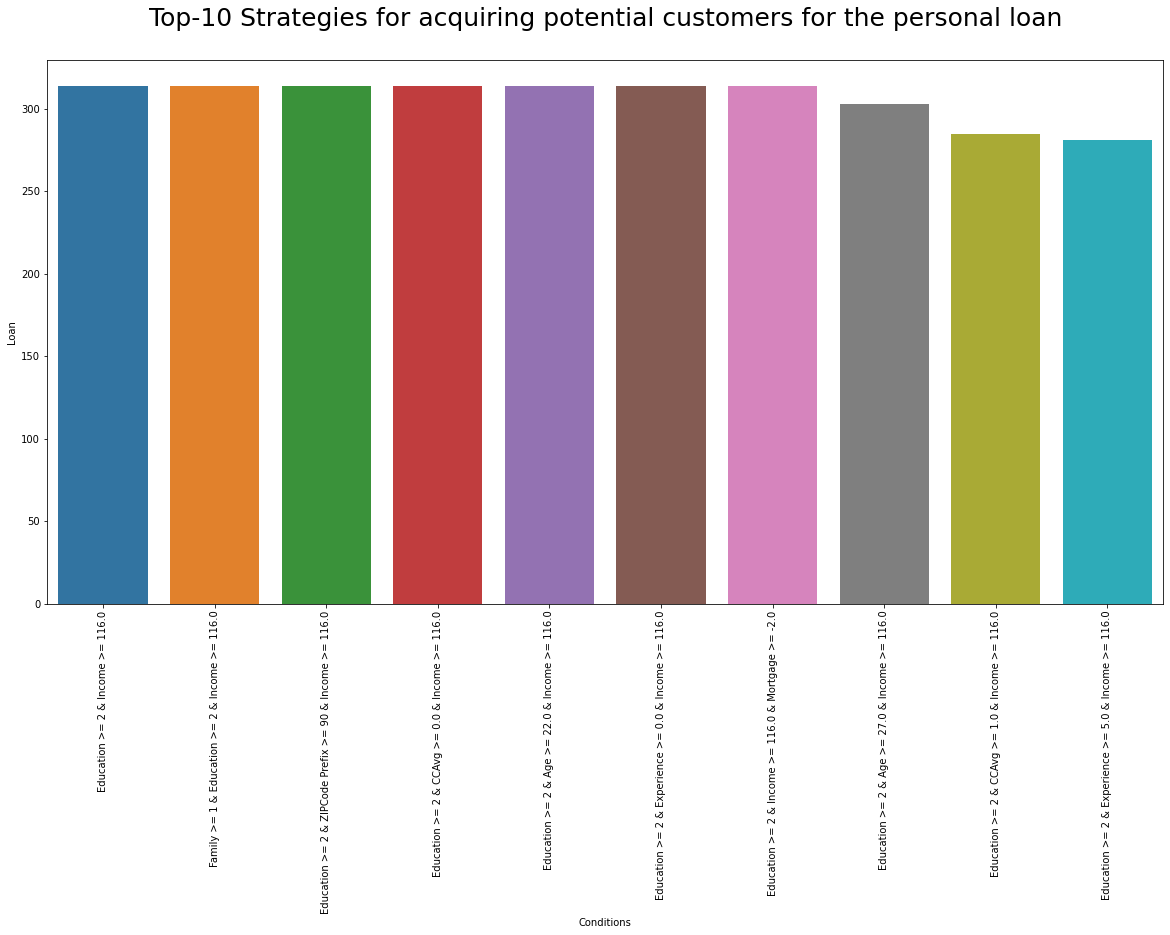

In [40]:
sns.barplot(x='Conditions',y='Loan',data=topn_df);
plt.xticks(rotation=90);
plt.title(f"Top-{topn} Strategies for acquiring potential customers for the personal loan\n",fontsize=25)
plt.show();